In [6]:
!ls

drive  sample_data


In [7]:
%cd /content/drive/MyDrive/PyTorch Training

/content/drive/.shortcut-targets-by-id/1apsDASdlLlmKwTgjbZpNTL_aSzggnARW/PyTorch Training


In [8]:
!pip install -q torchinfo

In [9]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torch import nn
from torchvision import transforms
from torchinfo import summary

In [10]:
"""
Contains functionality for creating PyTorch DataLoaders for
image classification data.
"""
import os

from torchvision import datasets, transforms
from torch.utils.data import DataLoader

NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):
    """Creates training and testing DataLoaders.

    Takes in a training directory and testing directory path and turns
    them into PyTorch Datasets and then into PyTorch DataLoaders.

    Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    transform: torchvision transforms to perform on training and testing data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

    Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
    """
    # Use ImageFolder to create Dataset(s)
    train_data = datasets.ImageFolder(train_dir, transform=transform)
    test_data = datasets.ImageFolder(test_dir, transform=transform)

    # Get class names
    class_names = train_data.classes

    # Turn images into data loaders
    train_dataloader = DataLoader(
        train_data,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True
    )
    test_dataloader = DataLoader(
        test_data,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True
    )
    return train_dataloader, test_dataloader, class_names

In [11]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [12]:
import os
import zipfile
import requests

from pathlib import Path


def download_data(source: str,
                  destination: str,
                  remove_source: bool = True) -> Path:
    """Downloads a zipped dataset from source and unzips to destination.

    Args:
        source (str): A link to a zipped file containing data.
        destination (str): A target directory to unzip data to.
        remove_source (bool): Whether to remove the source after downloading and extracting.

    Returns:
        pathlib.Path to downloaded data.

    Example usage:
        download_data(source="https://github.com/GilbertHarijanto/PyTorch-ViT-Paper-Replicating/blob/main/pizza_steak_sushi.zip",
                      destination="pizza_steak_sushi")
    """
    # Setup path to data folder
    data_path = Path("data/")
    image_path = data_path / destination

    # If the image folder doesn't exist, download it and prepare it...
    if image_path.is_dir():
        print(f"[INFO] {image_path} directory exists, skipping download.")
    else:
        print(f"[INFO] Did not find {image_path} directory, creating one...")
        image_path.mkdir(parents=True, exist_ok=True)

        # Download pizza, steak, sushi data
        target_file = Path(source).name
        with open(data_path / target_file, "wb") as f:
            request = requests.get(source)
            print(f"[INFO] Downloading {target_file} from {source}...")
            f.write(request.content)

        # Unzip pizza, steak, sushi data
        with zipfile.ZipFile(data_path / target_file, "r") as zip_ref:
            print(f"[INFO] Unzipping {target_file} data...")
            zip_ref.extractall(image_path)

        # Remove .zip file
        if remove_source:
            os.remove(data_path / target_file)

    return image_path

In [13]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

In [14]:
# Device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

# 1. Getting Data

In [15]:
data_20_percent_path = download_data(source="https://github.com/GilbertHarijanto/FoodVision/raw/main/pizza_steak_sushi_20_percent.zip",
                           destination="pizza_steak_sushi_20_percent")
data_20_percent_path


[INFO] data/pizza_steak_sushi_20_percent directory exists, skipping download.


PosixPath('data/pizza_steak_sushi_20_percent')

In [16]:
# Setup directory paths to train and test images
train_dir = data_20_percent_path / "train"
test_dir = data_20_percent_path / "test"

# 2. Creating an EffNetB2 feature extractor

In [17]:
# 1. Setup pretrained EffNetB2 weights
effnetb2_weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT

# 2. Get EffNetB2 transforms
effnetb2_transforms = effnetb2_weights.transforms()

# 3. Setup pretrained model
effnetb2 = torchvision.models.efficientnet_b2(weights=effnetb2_weights) # could also use weights="DEFAULT"

# 4. Freeze the base layers in the model
for param in effnetb2.parameters():
  param.requires_grad = False

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-c35c1473.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-c35c1473.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 54.2MB/s]


In [18]:
# Checkout EffNetB2 classifier head
effnetb2.classifier

Sequential(
  (0): Dropout(p=0.3, inplace=True)
  (1): Linear(in_features=1408, out_features=1000, bias=True)
)

In [19]:
# 5. Update the classifier head
effnetb2.classifier = nn.Sequential(
    nn.Dropout(p=0.3, inplace=True), # keep dropout layer same
    nn.Linear(in_features=1408, # keep in_features same
              out_features=3) # change out_features to suit the number of classes
)

### Creating a function to make an EffNetB2 feature extractor

In [20]:
def create_effnetb2_model(num_classes:int=3):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # 1, 2, 3. Create EffNetB2 pretrained weights, transforms, and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # 4. Freeze all alyers in base model
    for param in model.parameters():
      param.requires_grad = False

    # 5. Change classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes)
    )

    return model, transforms

In [21]:
effnetb2, effnetb2_transforms = create_effnetb2_model(num_classes=3)

In [22]:
from torchinfo import summary

# # Print EffNetB2 model summary
summary(effnetb2,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 3]               --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

### Creating DataLoaders for EffNetB2

In [23]:
# Setup DataLoaders
train_dataloader_effnetb2, test_dataloader_effnetb2, class_names = create_dataloaders(train_dir=train_dir,
                                                                                                 test_dir=test_dir,
                                                                                                 transform=effnetb2_transforms,
                                                                                                 batch_size=32)


### Training EffNetB2 feature extractor

In [24]:
# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

effnetb2_results = train(model=effnetb2,
                         train_dataloader=train_dataloader_effnetb2,
                         test_dataloader=test_dataloader_effnetb2,
                         epochs=10,
                         optimizer=optimizer,
                         loss_fn=loss_fn,
                         device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9651 | train_acc: 0.5854 | test_loss: 0.7407 | test_acc: 0.8977
Epoch: 2 | train_loss: 0.7367 | train_acc: 0.8000 | test_loss: 0.5916 | test_acc: 0.9318
Epoch: 3 | train_loss: 0.6091 | train_acc: 0.8333 | test_loss: 0.5033 | test_acc: 0.9131
Epoch: 4 | train_loss: 0.5218 | train_acc: 0.8875 | test_loss: 0.4689 | test_acc: 0.9381
Epoch: 5 | train_loss: 0.4524 | train_acc: 0.8875 | test_loss: 0.3964 | test_acc: 0.9506
Epoch: 6 | train_loss: 0.4137 | train_acc: 0.9000 | test_loss: 0.3755 | test_acc: 0.9443
Epoch: 7 | train_loss: 0.3260 | train_acc: 0.9396 | test_loss: 0.3591 | test_acc: 0.9443
Epoch: 8 | train_loss: 0.3259 | train_acc: 0.9271 | test_loss: 0.3197 | test_acc: 0.9472
Epoch: 9 | train_loss: 0.3023 | train_acc: 0.9292 | test_loss: 0.2945 | test_acc: 0.9688
Epoch: 10 | train_loss: 0.3276 | train_acc: 0.8896 | test_loss: 0.2860 | test_acc: 0.9506


### Inspecting EffNetB2 loss curves

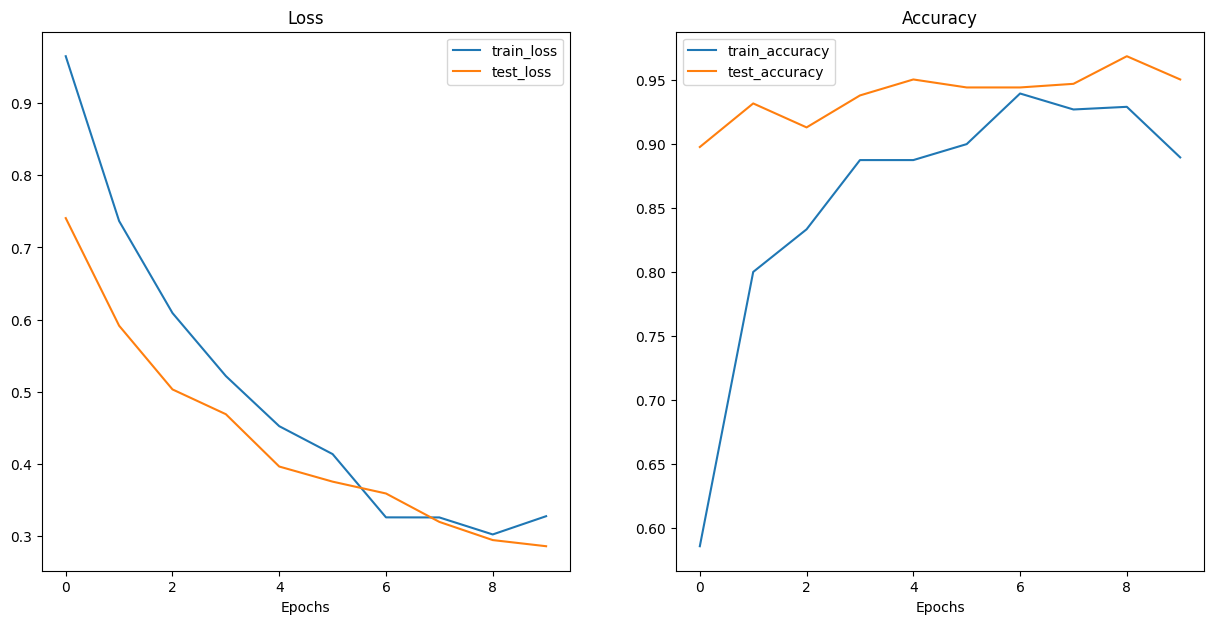

In [25]:
plot_loss_curves(effnetb2_results)

### Saving EffNetB2 feature extractor

In [26]:
"""
Contains various utility functions for PyTorch model training and saving.
"""
import torch
from pathlib import Path

def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
  """Saves a PyTorch model to a target directory.

  Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

  Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="tingvgg_model.pth")
  """
  # Create target directory
  target_dir_path = Path(target_dir)
  target_dir_path.mkdir(parents=True,
                        exist_ok=True)

  # Create model save path
  assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
  model_save_path = target_dir_path / model_name

  # Save the model state_dict()
  print(f"[INFO] Saving model to: {model_save_path}")
  torch.save(obj=model.state_dict(),
             f=model_save_path)

In [27]:
save_model(model=effnetb2,
           target_dir="models",
           model_name="effnetb2_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/effnetb2_pizza_steak_sushi_20_percent.pth


In [28]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_model_size = Path("models/effnetb2_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor model size: {pretrained_effnetb2_model_size} MB")

Pretrained EffNetB2 feature extractor model size: 29 MB


### Collecting EffNetB2 feature extractor stats

In [29]:
# Count number of parameters in EffNetB2
effnetb2_total_params =sum(torch.numel(param) for param in effnetb2.parameters())
effnetb2_total_params

7705221

In [30]:
# Create a dictionary with EffNetB2 statistics
effnetb2_stats = {"test_loss": effnetb2_results["test_loss"][-1],
                  "test_acc": effnetb2_results["test_acc"][-1],
                  "number_of_parameters": effnetb2_total_params,
                  "model_size (MB)": pretrained_effnetb2_model_size}
effnetb2_stats

{'test_loss': 0.2859827548265457,
 'test_acc': 0.9505681818181818,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29}

# 3. Creating a ViT feature extractor

In [31]:
vit = torchvision.models.vit_b_16()
vit.heads

Sequential(
  (head): Linear(in_features=768, out_features=1000, bias=True)
)

In [32]:
def create_vit_model(num_classes:int=3):
    """Creates a ViT-B/16 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of target classes. Defaults to 3.

    Returns:
        model (torch.nn.Module): ViT-B/16 feature extractor model.
        transforms (torchvision.transforms): ViT-B/16 image transforms.
    """
    # Create ViT_B_16 pretrained weights, transforms, and model
    weights = torchvision.models.ViT_B_16_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.vit_b_16(weights=weights)

    # Freeze all layers in model
    for param in model.parameters():
      param.requires_grad = False

    # Change the classifier head to suit our needs
    model.heads = nn.Sequential(nn.Linear(in_features=768, # keep this the same as the original model
                                          out_features=num_classes)) # update to reflect target number of classes

    return model, transforms

In [33]:
# Create ViT model and transforms
vit, vit_transforms = create_vit_model(num_classes=3)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:04<00:00, 83.6MB/s]


In [34]:
from torchinfo import summary

# # Print ViT feature extractor model summary
summary(vit,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
VisionTransformer (VisionTransformer)                        [1, 3, 224, 224]     [1, 3]               768                  Partial
├─Conv2d (conv_proj)                                         [1, 3, 224, 224]     [1, 768, 14, 14]     (590,592)            False
├─Encoder (encoder)                                          [1, 197, 768]        [1, 197, 768]        151,296              False
│    └─Dropout (dropout)                                     [1, 197, 768]        [1, 197, 768]        --                   --
│    └─Sequential (layers)                                   [1, 197, 768]        [1, 197, 768]        --                   False
│    │    └─EncoderBlock (encoder_layer_0)                   [1, 197, 768]        [1, 197, 768]        (7,087,872)          False
│    │    └─EncoderBlock (encoder_layer_1)                   [1, 197, 768]        [1, 1

### Create DataLoaders for ViT

In [35]:
# Setup ViT DataLoaders
train_dataloader_vit, test_dataloader_vit, class_names = create_dataloaders(train_dir=train_dir,
                                                                                       test_dir=test_dir,
                                                                                       transform=vit_transforms,
                                                                                       batch_size=32)


### Training ViT feature extractor

In [36]:
# Setup optimizer
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=1e-3)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss()

# Train ViT model
vit_results = train(model=vit,
                    train_dataloader=train_dataloader_vit,
                    test_dataloader=test_dataloader_vit,
                    epochs=10,
                    optimizer=optimizer,
                    loss_fn=loss_fn,
                    device=device)

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.6349 | train_acc: 0.7688 | test_loss: 0.2241 | test_acc: 0.9659
Epoch: 2 | train_loss: 0.2178 | train_acc: 0.9437 | test_loss: 0.1211 | test_acc: 0.9688
Epoch: 3 | train_loss: 0.1586 | train_acc: 0.9604 | test_loss: 0.0944 | test_acc: 0.9812
Epoch: 4 | train_loss: 0.1344 | train_acc: 0.9688 | test_loss: 0.0820 | test_acc: 0.9750
Epoch: 5 | train_loss: 0.1081 | train_acc: 0.9708 | test_loss: 0.0794 | test_acc: 0.9812
Epoch: 6 | train_loss: 0.0995 | train_acc: 0.9792 | test_loss: 0.0714 | test_acc: 0.9875
Epoch: 7 | train_loss: 0.0798 | train_acc: 0.9792 | test_loss: 0.0642 | test_acc: 0.9875
Epoch: 8 | train_loss: 0.0709 | train_acc: 0.9812 | test_loss: 0.0623 | test_acc: 0.9875
Epoch: 9 | train_loss: 0.0656 | train_acc: 0.9875 | test_loss: 0.0628 | test_acc: 0.9875
Epoch: 10 | train_loss: 0.0557 | train_acc: 0.9896 | test_loss: 0.0562 | test_acc: 0.9875


### Inspecting ViT loss curves

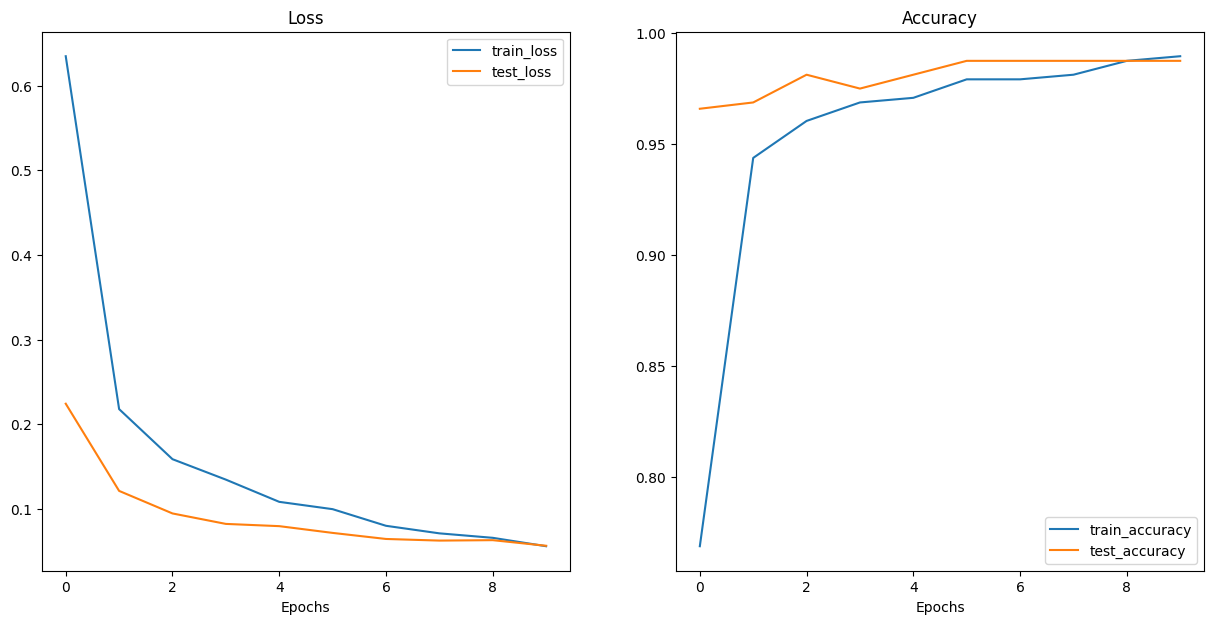

In [37]:
plot_loss_curves(vit_results)

### Saving ViT feature extractor

In [38]:
save_model(model=vit,
           target_dir="models",
           model_name="vit_pizza_steak_sushi_20_percent.pth")

[INFO] Saving model to: models/vit_pizza_steak_sushi_20_percent.pth


### Checking the size of ViT feature extractor

In [39]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_vit_model_size = Path("models/vit_pizza_steak_sushi_20_percent.pth").stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained ViT feature extractor model size: {pretrained_vit_model_size} MB")


Pretrained ViT feature extractor model size: 327 MB


### Collecting ViT feature extractor stats

In [40]:
# Count number of parameters in ViT
vit_total_params = sum(torch.numel(param) for param in vit.parameters())
vit_total_params

85800963

In [41]:
# Create ViT statistics dictionary
vit_stats = {"test_loss": vit_results["test_loss"][-1],
             "test_acc": vit_results["test_acc"][-1],
             "number_of_parameters": vit_total_params,
             "model_size (MB)": pretrained_vit_model_size}

vit_stats

{'test_loss': 0.0561965640168637,
 'test_acc': 0.9875,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327}

# Making predictions with out trained models and timing them

In [42]:
from pathlib import Path

# Get all test data paths
print(f"[INFO] Finding all filepaths ending with '.jpg' in directory: {test_dir}")
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))
test_data_paths[:5]

[INFO] Finding all filepaths ending with '.jpg' in directory: data/pizza_steak_sushi_20_percent/test


[PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2398925.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/771336.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/138961.jpg'),
 PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/61656.jpg')]

### Creating a function to make predictions across the test dataset

In [43]:
import pathlib
import torch

from PIL import Image
from timeit import default_timer as timer
from tqdm.auto import tqdm
from typing import List, Dict

# 1. Create a function to return a list of dictionaries with sample, truth label, prediction, prediction probability, and predicition time
def pred_and_store(paths: List[pathlib.Path],
                   model: torch.nn.Module,
                   transform: torchvision.transforms,
                   class_names: List[str],
                   device: str = "cuda" if torch.cuda.is_available() else "cpu") -> List[Dict]:
    # 2. Create an empty list to store prediction dictionaries
    pred_list = []

    # 3. Loop through target paths
    for path in tqdm(paths):
        # 4. Create empty dictionary to store prediction information for each sample
        pred_dict = {}

        # 5. Get the sample path and ground truth class name
        pred_dict["image_path"] = path
        class_name = path.parent.stem
        pred_dict["class_name"] = class_name

        # 6. Start the prediction timer
        start_time = timer()

        # 7. Open image path
        img = Image.open(path)

        # 8. Transform the image, add batch dimension and put image on target device
        transformed_image = transform(img).unsqueeze(0).to(device)

        # 9. Prepare model for inference by sending it to target device and turning on eval() mode
        model.to(device)
        model.eval()

        # 10. Get prediction probability, prediction label, and prediction calss
        with torch.inference_mode():
            pred_logit = model(transformed_image) # perform inference on target sample
            pred_prob = torch.softmax(pred_logit, dim=1) # turn logits into prediction probabilities
            pred_label = torch.argmax(pred_prob, dim=1) # turn prediction probabilities into prediction labels
            pred_class = class_names[pred_label.cpu()] # hardcode prediction class to be on CPU

            # 11. Make sure things in the dictionary are on CPU (required for inspecting predictions later on)
            pred_dict["pred_probs"] = round(pred_prob.unsqueeze(0).max().cpu().item(), 4)
            pred_dict["pred_class"] = pred_class

            # 12. End the timer and calculate time per pred
            end_time = timer()
            pred_dict["time_for_pred"] = round(end_time - start_time, 4)

            # 13. Does the pred match the true label?
            pred_dict["correct"]  = class_name == pred_class

            # 14. Add the dictionary to the list of preds
            pred_list.append(pred_dict)

    # 15. Return the list of prediction dictionaries
    return pred_list

### Making and timing predictions with EffNetB2

In [44]:
# Make predictions across test dataset with EffNetB2
effnetb2_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                          model=effnetb2,
                                          transform=effnetb2_transforms,
                                          class_names=class_names,
                                          device="cpu") # make predictions on CPU

  0%|          | 0/150 [00:00<?, ?it/s]

In [45]:
# Inspect the first 2 prediction dictionaries
effnetb2_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2398925.jpg'),
  'class_name': 'pizza',
  'pred_probs': 0.8936,
  'pred_class': 'pizza',
  'time_for_pred': 0.626,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
  'class_name': 'pizza',
  'pred_probs': 0.5945,
  'pred_class': 'pizza',
  'time_for_pred': 0.1392,
  'correct': True}]

In [46]:
# Turn the test_pred_dicts into a DataFrame
import pandas as pd
effnetb2_test_pred_df = pd.DataFrame(effnetb2_test_pred_dicts)
effnetb2_test_pred_df.head()

,image_path,class_name,pred_probs,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.8936,pizza,0.6260,True
1,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.5945,pizza,0.1392,True
2,data/pizza_steak_sushi_20_percent/test/pizza/7...,pizza,0.9015,pizza,0.1219,True
3,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.5459,pizza,0.1442,True
4,data/pizza_steak_sushi_20_percent/test/pizza/6...,pizza,0.7065,pizza,0.1239,True


In [47]:
# Check number of correct predictions
effnetb2_test_pred_df.correct.value_counts()

,count
correct,
True,143
False,7


In [48]:
# Find the average time per prediction
effnetb2_average_time_per_pred = round(effnetb2_test_pred_df.time_for_pred.mean(), 4)
print(f"EffNetB2 average time per prediction: {effnetb2_average_time_per_pred} seconds")

EffNetB2 average time per prediction: 0.145 seconds


In [49]:
# Add EffNetB2 average prediction time to stats dictionary
effnetb2_stats["time_per_pred_cpu"] = effnetb2_average_time_per_pred
effnetb2_stats

{'test_loss': 0.2859827548265457,
 'test_acc': 0.9505681818181818,
 'number_of_parameters': 7705221,
 'model_size (MB)': 29,
 'time_per_pred_cpu': 0.145}

### Making and timing predictions with ViT

In [50]:
# Make list of prediction dictionaries with ViT feature extractor model on test images
vit_test_pred_dicts = pred_and_store(paths=test_data_paths,
                                     model=vit,
                                     transform=vit_transforms,
                                     class_names=class_names,
                                     device="cpu")

  0%|          | 0/150 [00:00<?, ?it/s]

In [51]:
# Check the first couple of ViT predictions on the test dataset
vit_test_pred_dicts[:2]

[{'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/2398925.jpg'),
  'class_name': 'pizza',
  'pred_probs': 0.9981,
  'pred_class': 'pizza',
  'time_for_pred': 0.9061,
  'correct': True},
 {'image_path': PosixPath('data/pizza_steak_sushi_20_percent/test/pizza/129666.jpg'),
  'class_name': 'pizza',
  'pred_probs': 0.9885,
  'pred_class': 'pizza',
  'time_for_pred': 0.6183,
  'correct': True}]

In [52]:
# Turn vit_test_pred_dicts into a DataFrame
import pandas as pd
vit_test_pred_df = pd.DataFrame(vit_test_pred_dicts)
vit_test_pred_df.head()

,image_path,class_name,pred_probs,pred_class,time_for_pred,correct
0,data/pizza_steak_sushi_20_percent/test/pizza/2...,pizza,0.9981,pizza,0.9061,True
1,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9885,pizza,0.6183,True
2,data/pizza_steak_sushi_20_percent/test/pizza/7...,pizza,0.9983,pizza,0.5748,True
3,data/pizza_steak_sushi_20_percent/test/pizza/1...,pizza,0.9970,pizza,0.5639,True
4,data/pizza_steak_sushi_20_percent/test/pizza/6...,pizza,0.9853,pizza,0.8823,True


In [53]:
# Count the number of correct predictions
vit_test_pred_df.correct.value_counts()

,count
correct,
True,148
False,2


In [54]:
# Calculate average time per prediction for ViT model
vit_average_time_per_pred = round(vit_test_pred_df.time_for_pred.mean(), 4)
print(f"ViT average time per prediction: {vit_average_time_per_pred} seconds")

ViT average time per prediction: 0.7065 seconds


In [55]:
# Add average prediction time for ViT model on CPU
vit_stats["time_per_pred_cpu"] = vit_average_time_per_pred
vit_stats

{'test_loss': 0.0561965640168637,
 'test_acc': 0.9875,
 'number_of_parameters': 85800963,
 'model_size (MB)': 327,
 'time_per_pred_cpu': 0.7065}

In [56]:
# Turn stat dictionaries into DataFrame
df = pd.DataFrame([effnetb2_stats, vit_stats])

# Add column for model names
df["model"] = ["EffNetB2", "ViT"]

# Convert accuracy to percentages
df["test_acc"] = round(df["test_acc"] * 100, 2)

df

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu,model
0,0.285983,95.06,7705221,29,0.1450,EffNetB2
1,0.056197,98.75,85800963,327,0.7065,ViT


In [57]:
# Compare ViT to EffNetB2 across different characteristics
pd.DataFrame(data=(df.set_index("model").loc["ViT"] / df.set_index("model").loc["EffNetB2"]), # divide ViT statistics by EffNetB2 statistics
             columns=["ViT to EffNetB2 ratios"]).T

,test_loss,test_acc,number_of_parameters,model_size (MB),time_per_pred_cpu
ViT to EffNetB2 ratios,0.196503,1.038818,11.135432,11.275862,4.872414


### Visualizing the speed vs. performance tradeoff

mkdir: cannot create directory ‘images/’: File exists


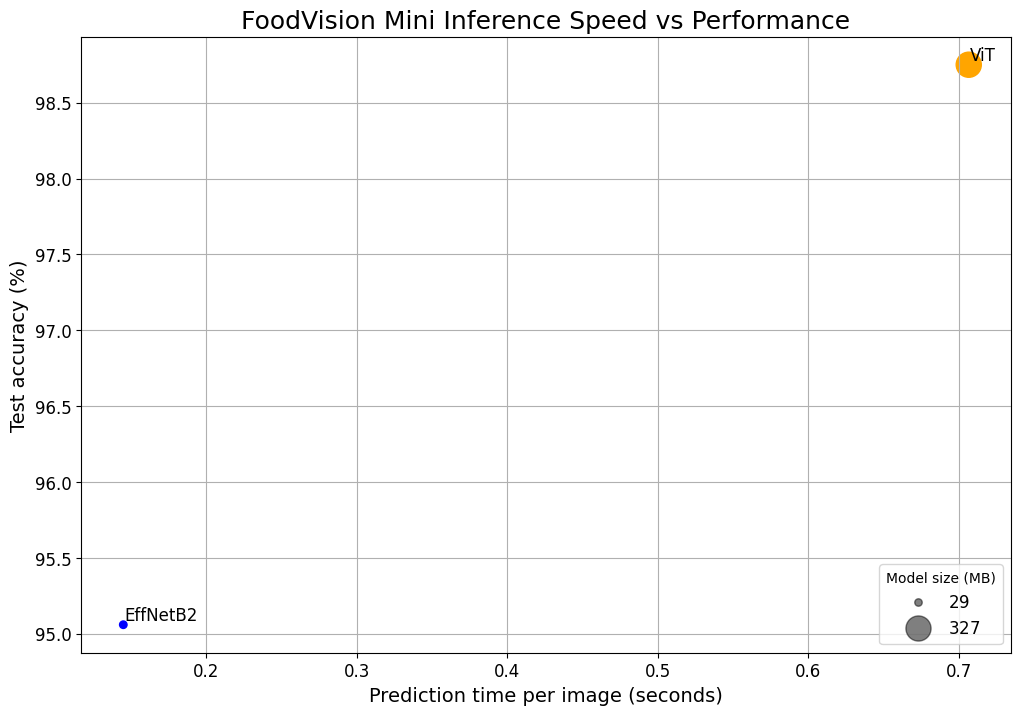

In [58]:
# 1. Create a plot from model comparison DataFrame
fig, ax = plt.subplots(figsize=(12, 8))
scatter = ax.scatter(data=df,
                     x="time_per_pred_cpu",
                     y="test_acc",
                     c=["blue", "orange"], # what colours to use?
                     s="model_size (MB)") # size the dots by the model sizes

# 2. Add titles, labels and customize fontsize for aesthetics
ax.set_title("FoodVision Mini Inference Speed vs Performance", fontsize=18)
ax.set_xlabel("Prediction time per image (seconds)", fontsize=14)
ax.set_ylabel("Test accuracy (%)", fontsize=14)
ax.tick_params(axis='both', labelsize=12)
ax.grid(True)

# 3. Annotate with model names
for index, row in df.iterrows():
    ax.annotate(text=row["model"], # note: depending on your version of Matplotlib, you may need to use "s=..." or "text=...", see: https://github.com/faustomorales/keras-ocr/issues/183#issuecomment-977733270
                xy=(row["time_per_pred_cpu"]+0.0006, row["test_acc"]+0.03),
                size=12)

# 4. Create a legend based on model sizes
handles, labels = scatter.legend_elements(prop="sizes", alpha=0.5)
model_size_legend = ax.legend(handles,
                              labels,
                              loc="lower right",
                              title="Model size (MB)",
                              fontsize=12)

# Save the figure
!mkdir images/
plt.savefig("images/foodvision-mini-inference-speed-vs-performance.jpg")

# Show the figure
plt.show()

# Bringing FoodVision Mini to life by creating a Gradio demo

In [59]:
!pip install -q gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 12.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.0/322.0 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.8/94.8 kB 8.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 97.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.5 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
torch 2.5.1+cu124 requires nvidia-cuda-cupti-cu12==12.4.127; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cuda-cupti-cu12 12.5.82 whic

In [60]:
import gradio as gr

### Creating a function to map our inputs and outputs

In [61]:
# Put EffNetB2 on CPU
effnetb2.to("cpu")

# Check the device
next(iter(effnetb2.parameters())).device


device(type='cpu')

In [62]:
from typing import Tuple, TypedDict

def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
      # Pass the transformed image through the model and turn prediction logits into prediction probabilities
      pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

In [63]:
import random
from PIL import Image

# Get a list of all test image filepaths
test_data_paths = list(Path(test_dir).glob("*/*.jpg"))

# Randomly select a test image path
random_image_path = random.sample(test_data_paths, k=1)[0]

# Open the target image
image = Image.open(random_image_path)
print(f"[INFO] Predicting on image at path: {random_image_path}\n")

# Predict on the target image and print out the outputs
pred_dict, pred_time = predict(img=image)
print(f"Prediction label and probability dictionary: \n{pred_dict}")
print(f"Prediction time: {pred_time} seconds")

[INFO] Predicting on image at path: data/pizza_steak_sushi_20_percent/test/steak/2069289.jpg

Prediction label and probability dictionary: 
{'pizza': 0.06296413391828537, 'steak': 0.9059178233146667, 'sushi': 0.031117964535951614}
Prediction time: 0.21094 seconds


### Creating a list of example images

In [64]:
import random
# Create a list of example inputs to our Gradio demo
example_list = [[str(filepath)] for filepath in random.sample(test_data_paths, k=3)]
example_list

[['data/pizza_steak_sushi_20_percent/test/sushi/1994748.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/715227.jpg'],
 ['data/pizza_steak_sushi_20_percent/test/sushi/2378406.jpg']]

### Building a Gradio interface

In [65]:
!pip install -q gradio

In [66]:
import gradio as gr

# Create title, description, and article strings
title = "FoodVision Mini 🍕🥩🍱"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak, or sushi."
article = "Created by Gilbert Harijanto"

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs
                             gr.Number(label="Prediction time(s)")], # our fn has 2 outputs, therefore we have 2 outputs
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch(debug=False, # print errors locally?
            share=True) # generate a publically sharable URL?

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://388a0d5405924621f7.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


# Turning FoodVision Mini Gradio Demo into a deployable app

In [67]:
import shutil
from pathlib import Path

# Create FoodVision mini demo path
foodvision_mini_demo_path = Path("demos/foodvision_mini/")

# Remove files that might already exist there and create new directory
if foodvision_mini_demo_path.exists():
    shutil.rmtree(foodvision_mini_demo_path)
# If the file doesn't exist, create it anyway
foodvision_mini_demo_path.mkdir(parents=True,
                                exist_ok=True)

# Check what's in the folder
!ls demos/foodvision_mini/

In [68]:
import shutil
from pathlib import Path

# 1. Create an examples directory
foodvision_mini_examples_path = foodvision_mini_demo_path / "examples"
foodvision_mini_examples_path.mkdir(parents=True, exist_ok=True)

# 2. Collect three random test dataset image paths
foodvision_mini_examples = [Path('data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg'),
                            Path('data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg')]

# 3. Copy the three random images to the examples directory
for example in foodvision_mini_examples:
    destination = foodvision_mini_examples_path / example.name
    print(f"[INFO] Copying {example} to {destination}")
    shutil.copy2(src=example, dst=destination)

[INFO] Copying data/pizza_steak_sushi_20_percent/test/sushi/592799.jpg to demos/foodvision_mini/examples/592799.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/steak/3622237.jpg to demos/foodvision_mini/examples/3622237.jpg
[INFO] Copying data/pizza_steak_sushi_20_percent/test/pizza/2582289.jpg to demos/foodvision_mini/examples/2582289.jpg


In [69]:
import os

# Get example filepaths in a list of lists
example_list = [["examples/" + example] for example in os.listdir(foodvision_mini_examples_path)]
example_list

[['examples/592799.jpg'], ['examples/3622237.jpg'], ['examples/2582289.jpg']]

### Moving trained EffNetB2 model to FoodVision Mini demo directory

In [70]:
import shutil

# Create a source path for our target model
effnetb2_foodvision_mini_model_path = "models/effnetb2_pizza_steak_sushi_20_percent.pth"

# Create a destination path for our target model
effnetb2_foodvision_mini_model_destination = foodvision_mini_demo_path / effnetb2_foodvision_mini_model_path.split("/")[1]

# Try to move the file
try:
    print(f"[INFO] Attempting to move {effnetb2_foodvision_mini_model_path} to {effnetb2_foodvision_mini_model_destination}")

    # Move the model
    shutil.move(src=effnetb2_foodvision_mini_model_path,
                dst=effnetb2_foodvision_mini_model_destination)

    print(f"[INFO] Model move complete.")

# If the model has already been moved, check if it exists
except:
    print(f"[INFO] No model found at {effnetb2_foodvision_mini_model_path}, perhaps its already been moved?")
    print(f"[INFO] Model exists at {effnetb2_foodvision_mini_model_destination}: {effnetb2_foodvision_mini_model_destination.exists()}")


[INFO] Attempting to move models/effnetb2_pizza_steak_sushi_20_percent.pth to demos/foodvision_mini/effnetb2_pizza_steak_sushi_20_percent.pth
[INFO] Model move complete.


# Turning EffNetB2 model into a Python script (`model.py`)

In [71]:
%%writefile demos/foodvision_mini/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # # Freeze all layers in base model
    # for param in model.parameters():
    #     param.requires_grad = False
    for name, param in model.features.named_parameters():
        layer_num = name.split('.')[0] if '.' in name else ''
        if layer_num.isdigit() and int(layer_num) >= 6:  # Unfreeze last 2-3 blocks
            param.requires_grad = True
        else:
            param.requires_grad = False


    # Change classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms

Writing demos/foodvision_mini/model.py


### Turning FoodVision Mini Gradio app into a Python script (`app.py`)

In [72]:
%%writefile demos/foodvision_mini/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from model import create_effnetb2_model
from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class
class_names = ["pizza", "steak", "sushi"]

### 2. Model and transforms preparation ###

# Create EffNetB2 model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=len(class_names)
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="effnetb2_pizza_steak_sushi_20_percent.pth",
        map_location=torch.device("cpu") # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a predicition label and prediction probability dictionary for each prediction
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio App ###

# Create title, description, and prediction time
title = "FoodVision Mini 🍕🥩🍱"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food as pizza, steak, or sushi."
article = "Created by Gilbert Harijanto"

# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create the Gradio demo
demo = gr.Interface(fn=predict, # mapping function from input to output
                    inputs=gr.Image(type="pil"), # what are the inputs?
                    outputs=[gr.Label(num_top_classes=3, label="Predictions"), # what are the outputs
                             gr.Number(label="Prediction time(s)")], # our fn has 2 outputs, therefore we have 2 outputs
                    # Create examples list from "examples/" directory
                    examples=example_list,
                    title=title,
                    description=description,
                    article=article)

# Launch the demo!
demo.launch()

Writing demos/foodvision_mini/app.py


In [73]:
%%writefile demos/foodvision_mini/requirements.txt
torch
torchvision
gradio

Writing demos/foodvision_mini/requirements.txt


# Deploying FoodVision mini app to HuggingFace Spaces

### Downloading FoodVision Mini app files

In [74]:
!ls demos/foodvision_mini

app.py	effnetb2_pizza_steak_sushi_20_percent.pth  examples  model.py  requirements.txt


In [75]:
# Change into and then zip the foodvision_mini folder but exclude certain files
!cd demos/foodvision_mini && zip -r ../foodvision_mini.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Mini app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_mini.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download(), please manually download.")

updating: app.py (deflated 57%)
updating: effnetb2_pizza_steak_sushi_20_percent.pth (deflated 8%)
updating: examples/ (stored 0%)
updating: examples/592799.jpg (deflated 1%)
updating: examples/3622237.jpg (deflated 0%)
updating: examples/2582289.jpg (deflated 17%)
updating: model.py (deflated 56%)
updating: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Running FoodVision Mini demo locally

If you download the `foodvision_mini.zip` file, you can test it locally by:

1. Unzipping the file.
2. Opening terminal or a command line prompt.
3. Changing into the `foodvision_mini` directory (`cd foodvision_mini`).
4. Creating an environment (`python3 -m venv env`).
5. Activating the environment (`source env/bin/activate`).
6. Installing the requirements (`pip install -r requirements.txt`, the "`-r`" is for recursive).
    * Note: This step may take 5-10 minutes depending on your internet connection. And if you're facing errors, you may need to upgrade `pip` first: `pip install --upgrade pip`.
7 Run the app (`python3 app.py`).


This should result in a Gradio demo just like the one we built above running locally on your machine at a URL such as `http://127.0.0.1:7860/`.

### Upload FoodVision Mini to HuggingFace Spaces

We can also share the app by embedding it: https://www.gradio.app/guides/sharing-your-app#embedding-hosted-spaces

In [76]:
# IPython is a library to help make Python interactive
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://gilbertharijanto-foodvision-mini.hf.space", width=900, height=750)

# Creating FoodVision Big

FoodVision Mini works well with 3 classes (pizza, steak, sushi). Stepping things up a notch by using all Food101 Classes.

### Creating a model for FoodVision Big + Transforms

In [77]:
# Create EffNetB2 model capable of fitting to 101 classes for Food101
effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

In [78]:
from torchinfo import summary

# # Get a summary of EffNetB2 feature extractor for Food101 with 101 output classes
summary(effnetb2_food101,
        input_size=(1, 3, 224, 224),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])


Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [1, 3, 224, 224]     [1, 101]             --                   Partial
├─Sequential (features)                                      [1, 3, 224, 224]     [1, 1408, 7, 7]      --                   False
│    └─Conv2dNormActivation (0)                              [1, 3, 224, 224]     [1, 32, 112, 112]    --                   False
│    │    └─Conv2d (0)                                       [1, 3, 224, 224]     [1, 32, 112, 112]    (864)                False
│    │    └─BatchNorm2d (1)                                  [1, 32, 112, 112]    [1, 32, 112, 112]    (64)                 False
│    │    └─SiLU (2)                                         [1, 32, 112, 112]    [1, 32, 112, 112]    --                   --
│    └─Sequential (1)                                        [1, 32, 112, 112]    [1, 1

In [79]:
# Create Food101 training data transforms (only perform data augmentation on the training images)
food101_train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.TrivialAugmentWide(),
    effnetb2_transforms,
])

In [80]:
print(f"Training transforms:\n{food101_train_transforms}\n")
print(f"Testing transforms:\n{effnetb2_transforms}")

Training transforms:
Compose(
    TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
    ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)
)

Testing transforms:
ImageClassification(
    crop_size=[288]
    resize_size=[288]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [81]:
# !rm -rf "/content/drive/MyDrive/PyTorch Training/data/food-101"

In [82]:
# !rm -rf "/content/drive/MyDrive/PyTorch Training/data/food-101.tar.gz"

In [83]:
from torchvision import datasets

# Setup data directory
from pathlib import Path
data_dir = Path("data")

# Get training data (~750 images x 101 food classes)
train_data = datasets.Food101(root=data_dir, # path to download data to
                              split="train", # dataset split to get
                              transform=food101_train_transforms, # perform data augmentation on training data
                              download=True) # want to download?

# Get testing data (~250 images x 101 food classes)
test_data = datasets.Food101(root=data_dir,
                             split="test",
                             transform=effnetb2_transforms, # perform normal EffNetB2 transforms on test data
                             download=True)


100%|██████████| 5.00G/5.00G [04:14<00:00, 19.6MB/s]


Extracting data/food-101.tar.gz to data


In [84]:
# Get Food101 class names
food101_class_names = train_data.classes

# View the first 10
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

### Creating a subset of Food101 dataset for faster experimenting

In [85]:
# def split_dataset(dataset:torchvision.datasets, split_size:float=0.2):
#     """Randomly splits a given dataset into two proportions based on split_size.

#     Args:
#         dataset (torchvision.datasets): A PyTorch Dataset, typically one from torchvision.datasets.
#         split_size (float, optional): How much of the dataset should be split?
#             E.g. split_size=0.2 means there will be a 20% split and an 80% split. Defaults to 0.2.

#     Returns:
#         tuple: (random_split_1, random_split_2) where random_split_1 is of size split_size*len(dataset) and
#             random_split_2 is of size (1-split_size)*len(dataset).
#     """
#     # Create split lengths based on original dataset length
#     length_1 = int(len(dataset) * split_size) # desired length
#     length_2 = len(dataset) - length_1 # remaining length

#     # Print out info
#     print(f"[INFO] Splitting dataset of length {len(dataset)} into splits of size: {length_1} ({int(split_size*100)}%), {length_2} ({int((1-split_size)*100)}%)")

#     # Create splits
#     random_split_1, random_split_2 = torch.utils.data.random_split(dataset,
#                                                                    lengths=[length_1, length_2])
#     return random_split_1, random_split_2


In [86]:
# # Create training 20% split of Food101
# train_data_food101_20_percent, _ = split_dataset(dataset=train_data,
#                                                  split_size=0.2)

# # Create testing 20% split of Food101
# test_data_food101_20_percent, _ = split_dataset(dataset=test_data,
#                                                 split_size=0.2)

# len(train_data_food101_20_percent), len(test_data_food101_20_percent)


### Turning Food101 (20%) datasets into `DataLoader`s

In [87]:
# import os
# import torch

# BATCH_SIZE = 32
# NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

# # Create Food101 20 percent training DataLoader
# train_dataloader_food101_20_percent = torch.utils.data.DataLoader(train_data_food101_20_percent,
#                                                                   batch_size=BATCH_SIZE,
#                                                                   shuffle=True,
#                                                                   num_workers=NUM_WORKERS)
# # Create Food101 20 percent testing DataLoader
# test_dataloader_food101_20_percent = torch.utils.data.DataLoader(test_data_food101_20_percent,
#                                                                  batch_size=BATCH_SIZE,
#                                                                  shuffle=False,
#                                                                  num_workers=NUM_WORKERS)


# Training FoodVision (20%) Big model

In [88]:
# # Setup optimizer
# optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
#                              lr=1e-3)

# # Setup loss function
# loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # throw in a little label smoothing because so many classes

# # Want to beat original Food101 paper with 20% of data, need 56.4%+ acc on test dataset
# effnetb2_food101_results = train(model=effnetb2_food101,
#                                         train_dataloader=train_dataloader_food101_20_percent,
#                                         test_dataloader=test_dataloader_food101_20_percent,
#                                         optimizer=optimizer,
#                                         loss_fn=loss_fn,
#                                         epochs=5,
#                                         device=device)


### Inspecting loss curves of FoodVision Big (20%)

In [89]:
# plot_loss_curves(effnetb2_food101_results)

### Saving and loading FoodVision Big (20%)

In [90]:
# # Create a model path
# effnetb2_food101_model_path = "effnetb2_food101_20_percent.pth"

# # Save FoodVision Big model
# save_model(model=effnetb2_food101,
#            target_dir="models",
#            model_name=effnetb2_food101_model_path)

In [91]:
# # Create Food101 compatible EffnetB2 instance
# loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# # Load the saved model's state_dict
# loaded_effnetb2_food101.load_state_dict(torch.load("models/effnetb2_food101_20_percent.pth"))

### Checking FoodVision Big model size (20%)

In [92]:
# from pathlib import Path

# # Get the model size in bytes then convert to megabytes
# pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
# print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

# Training Full model

### Turning Food101 datasets into `DataLoader`s

In [93]:
import os
import torch

BATCH_SIZE = 32
NUM_WORKERS = 2 if os.cpu_count() <= 4 else 4 # this value is very experimental and will depend on the hardware you have available, Google Colab generally provides 2x CPUs

# Create Food101 20 percent training DataLoader
train_dataloader_food101 = torch.utils.data.DataLoader(train_data,
                                                       batch_size=BATCH_SIZE,
                                                       shuffle=True,
                                                       num_workers=NUM_WORKERS)
# Create Food101 20 percent testing DataLoader
test_dataloader_food101 = torch.utils.data.DataLoader(test_data,
                                                      batch_size=BATCH_SIZE,
                                                      shuffle=False,
                                                      num_workers=NUM_WORKERS)


# Stuff

### Train FoodVision Big with 5 epochs

In [94]:
"""
Contains functions for training and testing a PyTorch model.
"""
import torch

from tqdm.auto import tqdm
from typing import Dict, List, Tuple
from torch.utils.tensorboard import SummaryWriter

# Create a writer with all default settings
writer = SummaryWriter()

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
  """Trains a PyTorch model for a single epoch.

  Turns a target PyTorch model to training mode and then
  runs through all of the required training steps (forward
  pass, loss calculation, optimizer step).

  Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
  """
  # Put model in train mode
  model.train()

  # Setup train loss and train accuracy values
  train_loss, train_acc = 0, 0

  # Loop through data loader data batches
  for batch, (X, y) in enumerate(dataloader):
      # Send data to target device
      X, y = X.to(device), y.to(device)

      # 1. Forward pass
      y_pred = model(X)

      # 2. Calculate  and accumulate loss
      loss = loss_fn(y_pred, y)
      train_loss += loss.item()

      # 3. Optimizer zero grad
      optimizer.zero_grad()

      # 4. Loss backward
      loss.backward()

      # 5. Optimizer step
      optimizer.step()

      # Calculate and accumulate accuracy metric across all batches
      y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
      train_acc += (y_pred_class == y).sum().item()/len(y_pred)

  # Adjust metrics to get average loss and accuracy per batch
  train_loss = train_loss / len(dataloader)
  train_acc = train_acc / len(dataloader)
  return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
  """Tests a PyTorch model for a single epoch.

  Turns a target PyTorch model to "eval" mode and then performs
  a forward pass on a testing dataset.

  Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

  Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
  """
  # Put model in eval mode
  model.eval()

  # Setup test loss and test accuracy values
  test_loss, test_acc = 0, 0

  # Turn on inference context manager
  with torch.inference_mode():
      # Loop through DataLoader batches
      for batch, (X, y) in enumerate(dataloader):
          # Send data to target device
          X, y = X.to(device), y.to(device)

          # 1. Forward pass
          test_pred_logits = model(X)

          # 2. Calculate and accumulate loss
          loss = loss_fn(test_pred_logits, y)
          test_loss += loss.item()

          # Calculate and accumulate accuracy
          test_pred_labels = test_pred_logits.argmax(dim=1)
          test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

  # Adjust metrics to get average loss and accuracy per batch
  test_loss = test_loss / len(dataloader)
  test_acc = test_acc / len(dataloader)
  return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          scheduler: torch.optim.lr_scheduler._LRScheduler,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        scheduler.step(test_acc)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [95]:
# Setup optimizer
optimizer = torch.optim.Adam(params=effnetb2_food101.parameters(),
                             lr=1e-3)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',           # Since we're monitoring accuracy (higher is better)
    factor=0.1,           # Multiply LR by this factor when reducing
    patience=2,           # Wait this many epochs with no improvement before reducing LR
    min_lr=1e-6,          # Don't reduce LR below this value
    verbose=True          # Print message when LR is reduced
)

# Setup loss function
loss_fn = torch.nn.CrossEntropyLoss(label_smoothing=0.1) # throw in a little label smoothing because so many classes

effnetb2_food101_results = train(model=effnetb2_food101,
                                       train_dataloader=train_dataloader_food101,
                                       test_dataloader=test_dataloader_food101,
                                       optimizer=optimizer,
                                       loss_fn=loss_fn,
                                       scheduler=scheduler,
                                       epochs=5,
                                       device=device)


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 2.9839 | train_acc: 0.4065 | test_loss: 2.1870 | test_acc: 0.6073
Epoch: 2 | train_loss: 2.6541 | train_acc: 0.4799 | test_loss: 2.1045 | test_acc: 0.6304
Epoch: 3 | train_loss: 2.6155 | train_acc: 0.4903 | test_loss: 2.0657 | test_acc: 0.6407
Epoch: 4 | train_loss: 2.6028 | train_acc: 0.4935 | test_loss: 2.0590 | test_acc: 0.6433
Epoch: 5 | train_loss: 2.5880 | train_acc: 0.4995 | test_loss: 2.0351 | test_acc: 0.6496


### Saving and Loading FoodVision Big 5 epochs

In [103]:
# Create a model path
effnetb2_food101_model_path = "effnetb2_food101.pth"

# Save FoodVision Big model
save_model(model=effnetb2_food101,
           target_dir="models",
           model_name=effnetb2_food101_model_path)

[INFO] Saving model to: models/effnetb2_food101.pth


In [104]:
# Create Food101 compatible EffnetB2 instance
loaded_effnetb2_food101, effnetb2_transforms = create_effnetb2_model(num_classes=101)

# Load the saved model's state_dict
loaded_effnetb2_food101.load_state_dict(torch.load("models/effnetb2_food101.pth"))

<ipython-input-104-4cc215949312>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_effnetb2_food101.load_state_dict(torch.load("models/effnetb2_food101.pth"))


<All keys matched successfully>

### Inspecting loss curves of FoodVision Big 5 epochs

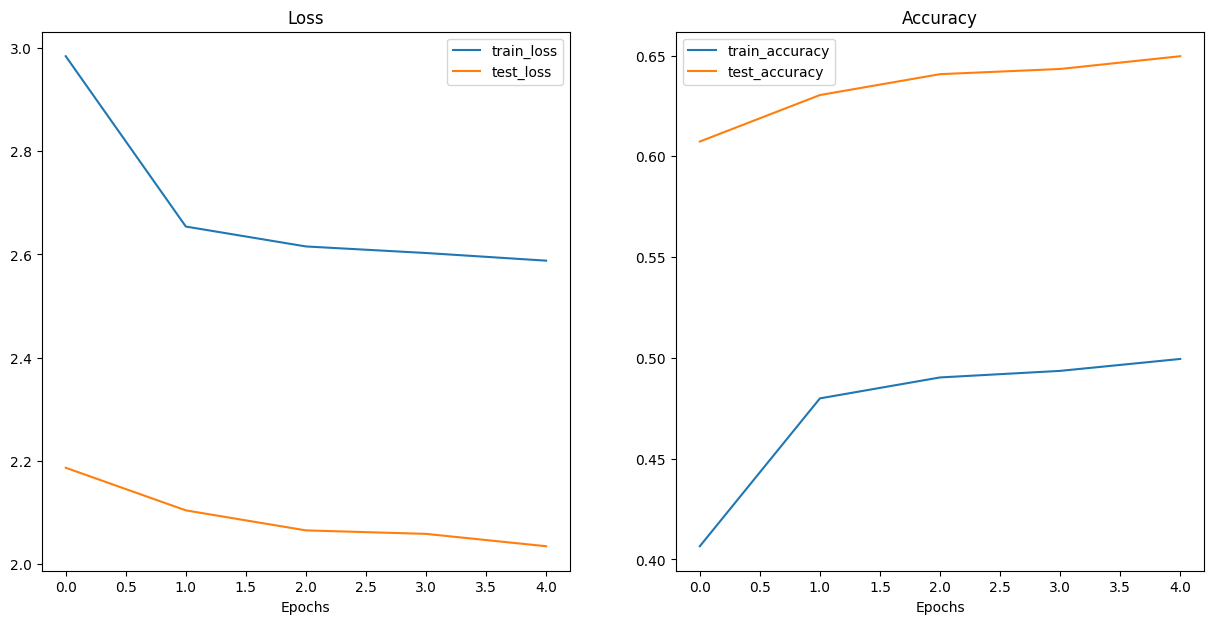

In [98]:
plot_loss_curves(effnetb2_food101_results)

### Checking FoodVision Big 5 epochs model size

In [105]:
from pathlib import Path

# Get the model size in bytes then convert to megabytes
pretrained_effnetb2_food101_model_size = Path("models", effnetb2_food101_model_path).stat().st_size // (1024*1024) # division converts bytes to megabytes (roughly)
print(f"Pretrained EffNetB2 feature extractor Food101 model size: {pretrained_effnetb2_food101_model_size} MB")

Pretrained EffNetB2 feature extractor Food101 model size: 30 MB


# Turning FoodVision Big model into a deployable app

In [106]:
from pathlib import Path

# Create FoodVision Big demo path
foodvision_big_demo_path = Path("demos/foodvision_big/")

# Make FoodVision Big demo directory
foodvision_big_demo_path.mkdir(parents=True, exist_ok=True)

# Make FoodVision Big demo examples directory
(foodvision_big_demo_path / "examples").mkdir(parents=True, exist_ok=True)

### Downloading an example image and moving it to the examples directory

In [109]:
# Download and move an example image
!wget https://raw.githubusercontent.com/GilbertHarijanto/PyTorch-ViT-Paper-Replicating/main/steak.jpg
!mv steak.jpg demos/foodvision_big/examples/steak.jpg

# Move trained model to FoodVision Big demo folder (will error if model is already moved)
!mv models/effnetb2_food101.pth demos/foodvision_big

--2025-02-21 02:06:47--  https://raw.githubusercontent.com/GilbertHarijanto/PyTorch-ViT-Paper-Replicating/main/steak.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1809920 (1.7M) [image/jpeg]
Saving to: ‘steak.jpg’

steak.jpg           100%[===================>]   1.73M  --.-KB/s    in 0.06s   

2025-02-21 02:06:47 (28.6 MB/s) - ‘steak.jpg’ saved [1809920/1809920]



### Saving Food101 class names to file (`class_names.txt`)

In [110]:
# Check out the first 10 Food101 class names
food101_class_names[:10]

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito']

In [111]:
# Create path to Food101 class names
foodvision_big_class_names_path = foodvision_big_demo_path / "class_names.txt"

# Write Food101 class names list to file
with open(foodvision_big_class_names_path, "w") as f:
    print(f"[INFO] Saving Food101 class names to {foodvision_big_class_names_path}")
    f.write("\n".join(food101_class_names)) # leave a new line between each class


[INFO] Saving Food101 class names to demos/foodvision_big/class_names.txt


In [112]:
# Open Food101 class names file and read each line into a list
with open(foodvision_big_class_names_path, "r") as f:
    food101_class_names_loaded = [food.strip() for food in  f.readlines()]

# View the first 5 class names loaded back in
food101_class_names_loaded[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [113]:
%%writefile demos/foodvision_big/model.py
import torch
import torchvision

from torch import nn


def create_effnetb2_model(num_classes:int=3):
    """Creates an EfficientNetB2 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to 3.

    Returns:
        model (torch.nn.Module): EffNetB2 feature extractor model.
        transforms (torchvision.transforms): EffNetB2 image transforms.
    """
    # Create EffNetB2 pretrained weights, transforms and model
    weights = torchvision.models.EfficientNet_B2_Weights.DEFAULT
    transforms = weights.transforms()
    model = torchvision.models.efficientnet_b2(weights=weights)

    # Freeze all layers in base model
    for param in model.parameters():
        param.requires_grad = False

    # Change classifier head
    model.classifier = nn.Sequential(
        nn.Dropout(p=0.3, inplace=True),
        nn.Linear(in_features=1408, out_features=num_classes),
    )

    return model, transforms


Writing demos/foodvision_big/model.py


### Turning FoodVision Big Gradio app into a Python script (`app.py`)

In [114]:
%%writefile demos/foodvision_big/app.py
### 1. Imports and class names setup ###
import gradio as gr
import os
import torch

from timeit import default_timer as timer
from typing import Tuple, Dict

# Setup class names
with open("class_names.txt", "r") as f: # reading them in from class_names.txt
    class_names = [food_name.strip() for food_name in  f.readlines()]

### 2. Model and transforms preparation ###

# Create model
effnetb2, effnetb2_transforms = create_effnetb2_model(
    num_classes=101, # could also use len(class_names)
)

# Load saved weights
effnetb2.load_state_dict(
    torch.load(
        f="effnetb2_food101.pth",
        map_location=torch.device("cpu"),  # load to CPU
    )
)

### 3. Predict function ###

# Create predict function
def predict(img) -> Tuple[Dict, float]:
    """Transforms and performs a prediction on img and returns prediction and time taken.
    """
    # Start the timer
    start_time = timer()

    # Transform the target image and add a batch dimension
    img = effnetb2_transforms(img).unsqueeze(0)

    # Put model into evaluation mode and turn on inference mode
    effnetb2.eval()
    with torch.inference_mode():
        # Pass the transformed image through the model and turn the prediction logits into prediction probabilities
        pred_probs = torch.softmax(effnetb2(img), dim=1)

    # Create a prediction label and prediction probability dictionary for each prediction class (this is the required format for Gradio's output parameter)
    pred_labels_and_probs = {class_names[i]: float(pred_probs[0][i]) for i in range(len(class_names))}

    # Calculate the prediction time
    pred_time = round(timer() - start_time, 5)

    # Return the prediction dictionary and prediction time
    return pred_labels_and_probs, pred_time

### 4. Gradio app ###

# Create title, description and article strings
title = "FoodVision Big 🍔🥬🍖"
description = "An EfficientNetB2 feature extractor computer vision model to classify images of food into [101 different classes]."
article = "Created by Gilbert Harijanto."


# Create examples list from "examples/" directory
example_list = [["examples/" + example] for example in os.listdir("examples")]

# Create Gradio interface
demo = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="pil"),
    outputs=[
        gr.Label(num_top_classes=5, label="Predictions"),
        gr.Number(label="Prediction time (s)"),
    ],
    examples=example_list,
    title=title,
    description=description,
    article=article,
)

# Launch the app!
demo.launch()

Writing demos/foodvision_big/app.py


### Creating a requirements file for FoodVision Big (`requirements.txt`)

In [115]:
%%writefile demos/foodvision_big/requirements.txt
torch
torchvision
gradio

Writing demos/foodvision_big/requirements.txt


### Downloading FoodVision Big app files

In [116]:
# Zip foodvision_big folder but exclude certain files
!cd demos/foodvision_big && zip -r ../foodvision_big.zip * -x "*.pyc" "*.ipynb" "*__pycache__*" "*ipynb_checkpoints*"

# Download the zipped FoodVision Big app (if running in Google Colab)
try:
    from google.colab import files
    files.download("demos/foodvision_big.zip")
except:
    print("Not running in Google Colab, can't use google.colab.files.download()")

  adding: app.py (deflated 55%)
  adding: class_names.txt (deflated 48%)
  adding: effnetb2_food101.pth (deflated 8%)
  adding: examples/ (stored 0%)
  adding: examples/steak.jpg (deflated 4%)
  adding: model.py (deflated 54%)
  adding: requirements.txt (deflated 4%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>